Import packages

In [82]:
import pandas as pd
import janitor
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np


pd.options.display.max_seq_items = 2000

Ingest data

In [83]:
file_path = '../data/CredLens Data File - CredLens Data File.csv'
fc_data = pd.read_csv(file_path)
fc_data.shape

(1999, 28)

Column names 

In [84]:
column_names = fc_data.columns
column_names

Index(['FirstName', 'MiddleInitial', 'LastName', 'BirthDate', 'Degree',
       'Major1', 'MajorID1', 'CognateID1', 'StudentUID', 'ExpectedGradTerm',
       'StudentSSN', 'Email1', 'Address1', 'Address2', 'City', 'State',
       'ZipCode', 'Phone1', 'Phone2', 'MobilePhone', 'GraduationDate',
       'Cohort', 'Gender', 'EthnicOrigin', 'IsHispanic', 'CIPCode', 'Campus',
       'CostType'],
      dtype='object')

Clean the names 

In [85]:
fc_data = fc_data.clean_names()

Clean SSN 

In [86]:
# Remove dashes from SSNs, keeping NaN values unchanged
fc_data["ssn"] = fc_data["studentssn"].str.replace("-", "", regex=True)
# Keep rows where 'ssn' is either NaN or matches exactly 9 digits
fc_data["ssn"] = fc_data["ssn"].where(fc_data["ssn"].str.fullmatch(r"\d{9}"), np.nan)

fc_data.shape

/var/folders/tx/5kc1s5j56ks8n7b45l51_3vw0000gn/T/ipykernel_24953/1706472411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_data["ssn"] = fc_data["studentssn"].str.replace("-", "", regex=True)
/var/folders/tx/5kc1s5j56ks8n7b45l51_3vw0000gn/T/ipykernel_24953/1706472411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_data["ssn"] = fc_data["ssn"].where(fc_data["ssn"].str.fullmatch(r"\d{9}"), np.nan)


(1999, 29)

Clean the dates in yyyymmdd format 

In [87]:
fc_data["birthdate"] = pd.to_datetime(fc_data["birthdate"]).dt.strftime('%Y%m%d')
fc_data["graduationdate"] = pd.to_datetime(fc_data["graduationdate"]).dt.strftime('%Y%m%d')

/var/folders/tx/5kc1s5j56ks8n7b45l51_3vw0000gn/T/ipykernel_24953/3110799253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_data["birthdate"] = pd.to_datetime(fc_data["birthdate"]).dt.strftime('%Y%m%d')
/var/folders/tx/5kc1s5j56ks8n7b45l51_3vw0000gn/T/ipykernel_24953/3110799253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_data["graduationdate"] = pd.to_datetime(fc_data["graduationdate"]).dt.strftime('%Y%m%d')


Clean states names to code states 

In [88]:
#FC data is already in this format 
fc_data.state.value_counts().head()

state
MA    1846
FL      18
NH      14
RI      12
TX      11
Name: count, dtype: int64

Create age bucket

In [89]:
def calculate_age_bucket(row):
    """
    Calculate the age bucket based on birthdate and graduationdate.
    The input should be a row containing 'birthdate' and 'graduationdate' in 'yyyymmdd' format.
    """
    try:
        # Convert to datetime
        birthdate = datetime.strptime(row["birthdate"], '%Y%m%d')
        graduationdate = datetime.strptime(row["graduationdate"], '%Y%m%d')

        # Calculate age at graduation date
        age = graduationdate.year - birthdate.year - ((graduationdate.month, graduationdate.day) < (birthdate.month, birthdate.day))

        # Assign age bucket
        if age < 18:
            return "Under 18"
        elif 18 <= age <= 24:
            return "18-24"
        elif 25 <= age <= 34:
            return "25-34"
        elif 35 <= age <= 44:
            return "35-44"
        elif 45 <= age <= 54:
            return "45-54"
        elif 55 <= age <= 64:
            return "55-64"
        else:
            return "65 or over"
    except Exception as e:
        return "Invalid Date"

fc_data["age_bucket"] = fc_data.apply(calculate_age_bucket, axis=1)

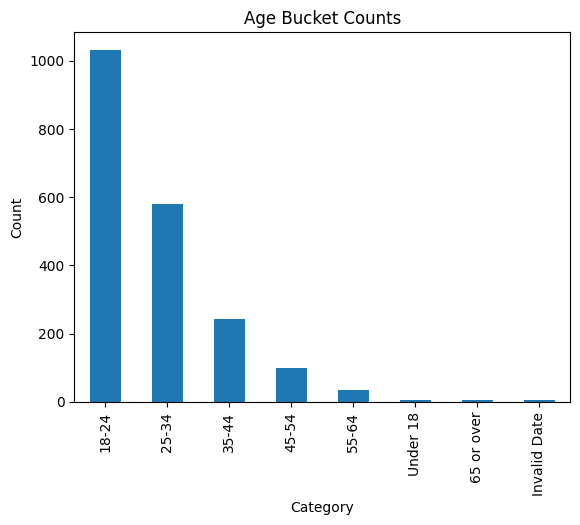

In [90]:
category_counts = fc_data['age_bucket'].value_counts()
category_counts.plot(kind='bar')
plt.title('Age Bucket Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

Make address1 contain both address1 and address2 

In [91]:
fc_data['address1'] = fc_data['address1'] + (' ' + fc_data['address2']).fillna('')

Rename variables for golden record standard in snake_case format

In [92]:
fc_data.rename(columns={
    'firstname': 'first_name',
    'middleinitial': 'middle_name', 
    'lastname': 'last_name', 
    'birthdate': 'dob', 
    'degree': 'credential_type', 
    'majorid1': 'credential_name', 
    'street_line_1' : 'address1', 
    'phone1': 'phone_number', 
    'graduationdate': 'credential_award_date', 
    'ethnicorigin': 'race_ethnicity', 
    'cipcode' : 'custom_attribute_1', 
    'age_bucket': 'age_bucket_at_cred_award'
}, inplace=True)

Add transaction columns

In [93]:
fc_data['tx_date'] = 20241007 
fc_data['organization_name'] = 'Franklin Cummings'


Order the columns

In [97]:
desired_order = ['first_name', 
                 'middle_name', 
                 'last_name', 
                 'ssn', 
                 'address1', 
                 'city', 
                 'state', 
                 'zipcode', 
                 'credential_award_date', 
                 'credential_type', 
                 'credential_name', 
                 'race_ethnicity', 
                 'gender', 
                 'age_bucket_at_cred_award', 
                 'custom_attribute_1', 
                 'tx_date', 
                 'organization_name'
                 ]

fc_data = fc_data[desired_order]

In [100]:
fc_data

,first_name,middle_name,last_name,ssn,address1,city,state,zipcode,credential_award_date,credential_type,credential_name,race_ethnicity,gender,age_bucket_at_cred_award,custom_attribute_1,tx_date,organization_name
0,Steve,NaN,Alexis,285313310,73 Heritage Land,Leominster,MA,1453,20220504,ASSOCIATE IN SCIENCE,7,BLACK OR AFRICAN AMERICAN,Male,25-34,47.0604,20241007,Franklin Cummings
1,Amarilio,J,Veiga,014907473,111 Park Street,Boston,MA,2122,20170503,ASSOCIATE IN SCIENCE,7,CAPE VERDEAN,Male,25-34,47.0604,20241007,Franklin Cummings
2,Brian,Edilson,Morales,022788180,40 John Street Apt. 1,Chelsea,MA,2150,20160505,ASSOCIATE IN SCIENCE,7,HISPANIC/LATINO,Male,18-24,47.0604,20241007,Franklin Cummings
3,Daniel,NaN,Andrews,026767205,3 B Street,Lynn,MA,1905,20170503,ASSOCIATE IN SCIENCE,7,WHITE,Male,18-24,47.0604,20241007,Franklin Cummings
4,Ryan,Patrick,Chetwynd,029860804,28 Wentworth Rd,Quincy,MA,2170,20231218,ASSOCIATE IN SCIENCE,7,WHITE,Male,18-24,47.0604,20241007,Franklin Cummings
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,Abdellah,NaN,Fakri,093815287,84 Shirley Ave,Revere,MA,2151,20240507,CERTIFICATE OF PROFICIENCY,138,NON-DISCLOSED,Male,25-34,15.0303,20241007,Franklin Cummings
1995,Antonio,NaN,Hall,587935582,3 Fuller St Apt 3,Boston,MA,2124,20240507,CERTIFICATE OF PROFICIENCY,138,BLACK OR AFRICAN AMERICAN,Male,18-24,15.0303,20241007,Franklin Cummings
1996,John,Morgan,Dixon,140685708,3 Pudding Brook Dr.,Pembroke,MA,2359,20240507,CERTIFICATE OF PROFICIENCY,138,NON-DISCLOSED,Male,55-64,15.0303,20241007,Franklin Cummings
1997,Nicholas,David,Hilderbrand,237451339,535 Woonasquatucket,N. Providence,RI,2911,20240507,CERTIFICATE OF PROFICIENCY,138,WHITE,Male,35-44,15.0303,20241007,Franklin Cummings
